In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

##  Loading Dataset

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/Telecom_customer_churn.csv")

Problem Statement:
Customer churn is when a company’s customers stop doing business with that company. Businesses are very keen on measuring churn because keeping an existing customer is far less expensive than acquiring a new customer. New business involves working leads through a sales funnel, using marketing and sales budgets to gain additional customers. Existing customers will often have a higher volume of service consumption and can generate additional customer referrals.

Customer retention can be achieved with good customer service and products. But the most effective way for a company to prevent attrition of customers is to truly know them. The vast volumes of data collected about customers can be used to build churn prediction models. Knowing who is most likely to defect means that a company can prioritise focused marketing efforts on that subset of their customer base.

Preventing customer churn is critically important to the telecommunications sector, as the barriers to entry for switching services are so low. 

You will examine customer data from IBM Sample Data Sets with the aim of building and comparing several customer churn prediction models.

In [3]:
data.shape # 7043 rows and 21 columns

(7043, 21)

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### Our Target variable constites only 2 values and are categorical, Hence this is a classification problem

In [6]:
#Let's see all the columns in our dataset
data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

### Checking for missing values

In [7]:
data.isna().sum() # We can see that there is no missing values in this dataset

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# Let's see statistics of our data
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#### Observations
##### 1 SeniorCitizen seems to be a binary value
##### 2 tenure is in months
##### 3 Minimum monthly charge is 18.25 and maximum is  118.75
##### 4 75% customers have a tenure of less than 55 months  

In [9]:
# Let's know how many values are in Churn column
data["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

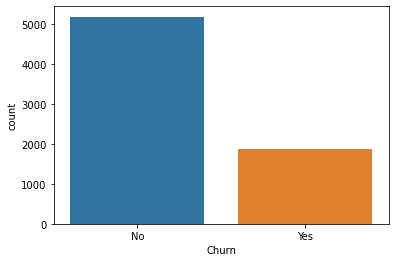

In [10]:
#Visualize
sns.countplot(data["Churn"]);

#### More number of customers are staying with the company and less umber are leaving
#### There is a class imbalance problem we need to take care

In [11]:
n_retained = data[data["Churn"] == 'No'].shape[0]
n_churned = data[data["Churn"] == 'Yes'].shape[0]

print(n_retained/(n_retained + n_churned)*100, '% of customers stayed')
print(n_churned/(n_retained + n_churned)*100, '% of customers left')

73.4630129206304 % of customers stayed
26.536987079369588 % of customers left


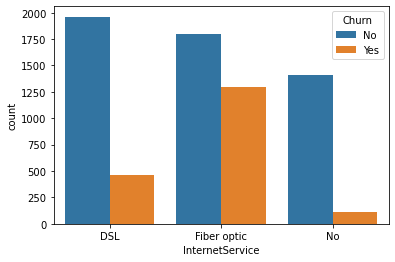

In [13]:
#Visualize the churn count for Internet service
sns.countplot(x = 'InternetService', hue = 'Churn', data = data);

#### Most of the customers that are not churning is having DSL internet service
#### Most of the customers that are leaving are having Fiber Optics internet service

array([<AxesSubplot:title={'center':'tenure'}>,
       <AxesSubplot:title={'center':'MonthlyCharges'}>], dtype=object)

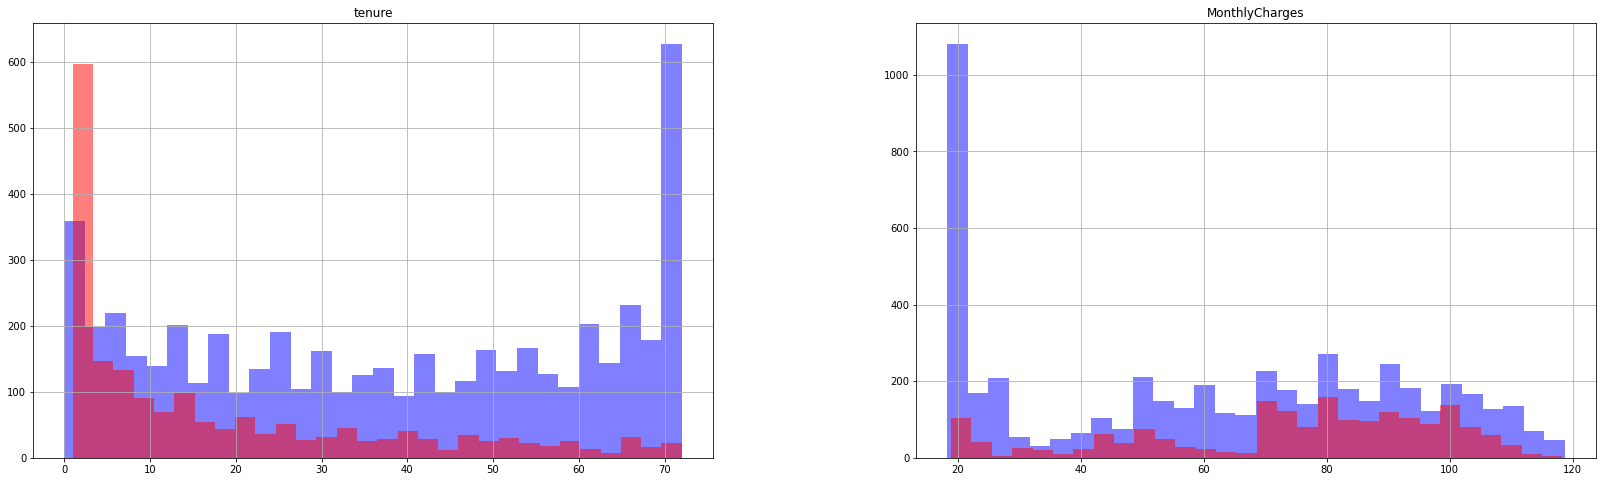

In [16]:
num_features = ['tenure', 'MonthlyCharges']
fig, ax = plt.subplots(1,2, figsize=(28,8))
data[data.Churn == 'No'][num_features].hist(bins = 30, color = 'blue', alpha = 0.5, ax = ax)
data[data.Churn == 'Yes'][num_features].hist(bins = 30, color = 'red', alpha = 0.5, ax = ax)

#### customers leaving are having low tenure and customers retained are having high tenure
#### More number of customers retained when the monthly charges are kept low and max customers leave when  having monthly charges between 70 to 101

In [21]:
# Remove unnecessary columns
cleaned_data = data.drop('customerID', axis = 1)

In [25]:
#converting all non-numeric columns to numeric columns
from sklearn.preprocessing import LabelEncoder
for column in cleaned_data.columns:
    if cleaned_data[column].dtype == np.number:
        continue
    cleaned_data[column] = LabelEncoder().fit_transform(cleaned_data[column])

In [26]:
cleaned_data.dtypes

gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges          int32
Churn                 int32
dtype: object

In [27]:
X = cleaned_data.drop('Churn', axis = 1)
y = cleaned_data['Churn']

X = StandardScaler().fit_transform(X)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

In [29]:
model = LogisticRegression()

model.fit(x_train, y_train)

LogisticRegression()

In [31]:
model.score(x_train, y_train)

0.8046194623248769

In [32]:
model.score(x_test, y_test)

0.8001135718341851

In [33]:
predictions = model.predict(x_test)
#print(predictions)

In [34]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1321
           1       0.62      0.51      0.56       440

    accuracy                           0.80      1761
   macro avg       0.73      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761

